In this lab we'll demonstrate several common techniques and helpful tools used in a model building process:

- Use Sklearn to generate polynomial features and rescale them
- Create folds for cross-validation
- Perform a grid search to optimize hyper-parameters using cross-validation
- Create pipelines to perform grids search in less code
- Improve upon a baseline model incrementally by adding in more complexity

This lab will require using several Sklearn classes. It would be helpful to refer to appropriate documentation:
- http://scikit-learn.org/stable/modules/preprocessing.html
- http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
- http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- http://scikit-learn.org/stable/modules/pipeline.html#pipeline

Also, here is a helpful tutorial that explains how to use much of the above:
- https://civisanalytics.com/blog/data-science/2016/01/06/workflows-python-using-pipeline-gridsearchcv-for-compact-code/

Like always, let's first load in the data.


In [1]:
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline

cwd = os.getcwd()
datadir = '/'.join(cwd.split('/')[0:-1]) + '/data/'

data = pd.read_csv(datadir + 'Cell2Cell_data.csv', header=0, sep=',')

#Randomly sort the data:
data = data.sample(frac = 1)
data.columns

Index(['revenue', 'outcalls', 'incalls', 'months', 'eqpdays', 'webcap',
       'marryyes', 'travel', 'pcown', 'creditcd', 'retcalls', 'churndep'],
      dtype='object')

Next we're going to prep the data. From prior analysis (Churn Case Study) we learned that we can drop a few variables, as they are either highly redundant or don't carry a strong relationship with the outcome.

After dropping, we're going to use the SkLearn KFold class to set up cross validation fold indexes.

In [2]:
# Prior analysis (from Churn Case study) has shown that we can drop a few redundant variables
# We want to drop a few to speed up later calculations
dropvar_list = ["incalls", "creditcd", "marryyes", "travel", "pcown"]
data_subset = data.drop(dropvar_list, 1)

# Set up X and Y
X = data_subset.drop("churndep", 1)
Y = data_subset["churndep"]

# Use Kfold to create 4 folds
kfolds = KFold(n_splits=4)

Next let's use cross-validation to build a baseline model. We're going to use LR with no feature pre-processing. We're going to look at both L1 and L2 regularization with different weights. We can do this very succinctly with SkLearns GridSearchCV package.

In [11]:
import numpy as np

In [43]:
# 1st, set up a paramater grid
param_grid_lr = {"C": [10 ** i for i in range(-3, 3)], "penalty": ["l1", "l2"]}

# 2nd, call the GridSearchCV class, use LogisticRegression and 'roc_auc' for scoring
lr_grid_search = GridSearchCV(
    LogisticRegression(solver="liblinear"),
    param_grid=param_grid_lr,
    scoring="roc_auc",
    error_score=np.nan,
    cv=kfolds,
)
lr_grid_search.fit(X, Y)

# 3rd, get the score of the best model and print it
best_1 = lr_grid_search.best_score_
print(lr_grid_search.best_score_)
print(lr_grid_search.best_params_)

0.5856481076634575
{'C': 100, 'penalty': 'l1'}


In [24]:
#Next let's look at the best-estimator chosen to see what the parameters were
lr_grid_search.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Now let's see if we can beat this by standardizing the features. We'll approach this using the GridSearchCV class but also build a pipeline. Later we'll extend the pipeline to allow for feature engineering as well.

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create a set of steps. All but the last step is a transformer (something that processes data).
# Build a list of steps, where the first is StandardScaler and the second is LogisticRegression
# The last step should be an estimator.

steps = [("scaler", StandardScaler()), ("lr", LogisticRegression(solver="liblinear"))]

# Now set up the pipeline
pipeline = Pipeline(steps=steps)

# Now set up the parameter grid, paying close to the correct convention here
parameters_scaler = dict(
    lr__C=[10 ** i for i in range(-3, 3)], lr__penalty=["l1", "l2"]
)

# Now run another grid search
lr_grid_search_scaler = GridSearchCV(
    pipeline, param_grid=parameters_scaler, cv=kfolds, scoring="roc_auc"
)

# Don't forget to fit this GridSearchCV pipeline
# Student put code here
lr_grid_search_scaler.fit(X, Y)

# Again, print the score of the best model
best_2 = lr_grid_search_scaler.best_score_
print(lr_grid_search_scaler.best_score_)
print(lr_grid_search_scaler.best_params_)

0.5873793167324227
{'lr__C': 0.01, 'lr__penalty': 'l1'}


Now that we've built a pipeline estimator that performs feature scaling and then logistic regression, let's add to it a feature engineering step. We'll then again use GridSearchCV to find an optimal parameter configuration and see if we can beat our best score above.

In [37]:
from sklearn.preprocessing import PolynomialFeatures

# Create a set of steps. All but the last step is a transformer (something that processes data).
# Step 1 - PolynomialFeatures
# Step 2 - StandardScaler
# Step 3 - LogisticRegression

steps_poly = [
    ("poly_features", PolynomialFeatures()),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver="liblinear")),
]

# Now set up the pipeline
pipeline_poly = Pipeline(steps=steps_poly)

# Now set up a new parameter grid, use the same paramaters used above for logistic regression,
# but add polynomial features up to degree 2 with and without interactions.
parameters_poly = dict(
    lr__C=[10 ** i for i in range(-3, 3)],
    lr__penalty=["l1", "l2"],
    poly_features__degree=[1, 2],
    poly_features__interaction_only=[True, False],
)

# Now run another grid search
lr_grid_search_poly = GridSearchCV(
    pipeline_poly, param_grid=parameters_poly, cv=kfolds, scoring="roc_auc"
)
lr_grid_search_poly.fit(X, Y)

best_3 = lr_grid_search_poly.best_score_
print(best_3)
print(lr_grid_search_poly.best_params_)

0.592147559487444
{'lr__C': 1, 'lr__penalty': 'l1', 'poly_features__degree': 2, 'poly_features__interaction_only': False}


Now make a bar chart to plot results

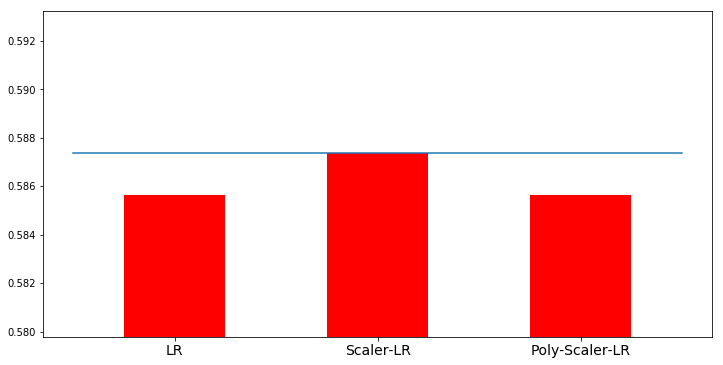

In [51]:
import numpy as np
results = np.array([best_1, best_2, best_3])
labs = ['LR', 'Scaler-LR', 'Poly-Scaler-LR']

fig = plt.figure(facecolor = 'w', figsize = (12, 6))
ax = plt.subplot(111)

width = 0.5
ind = np.arange(3)
rec = ax.bar(ind + width, results, width, color='r')

ax.set_xticks(ind + width)
ax.set_xticklabels(labs, size = 14)
ax.set_ylim([min(results)*0.99, max(results)*1.01])

plt.plot(np.arange(4), max(results) * np.ones(4))

In [47]:
best_3

0.5856495404154151